In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
PATH = os.path.join(os.getcwd(), 'data/vkyn01-dataset')

In [3]:
print(PATH)

C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset


In [4]:
train_dir = os.path.join(PATH, 'train')
print(train_dir)
validation_dir = os.path.join(PATH, 'val')
print(validation_dir)

C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset\train
C:\Users\modernpacifist\Documents\github-repositories\magistracy-diploma\notebooks\data/vkyn01-dataset\val


In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 16605 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 4158 files belonging to 2 classes.


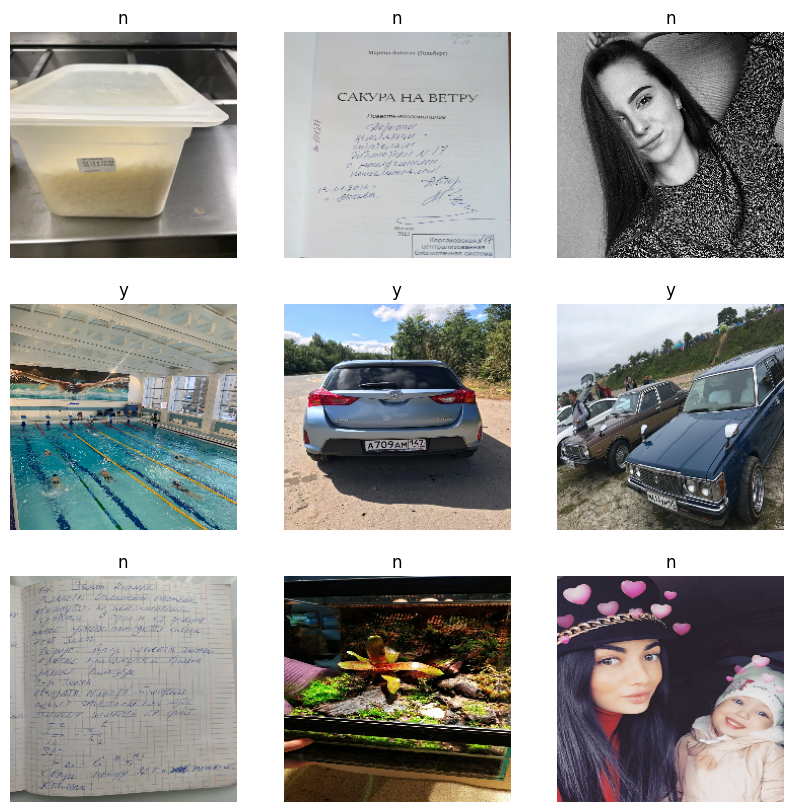

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 104
Number of test batches: 26


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

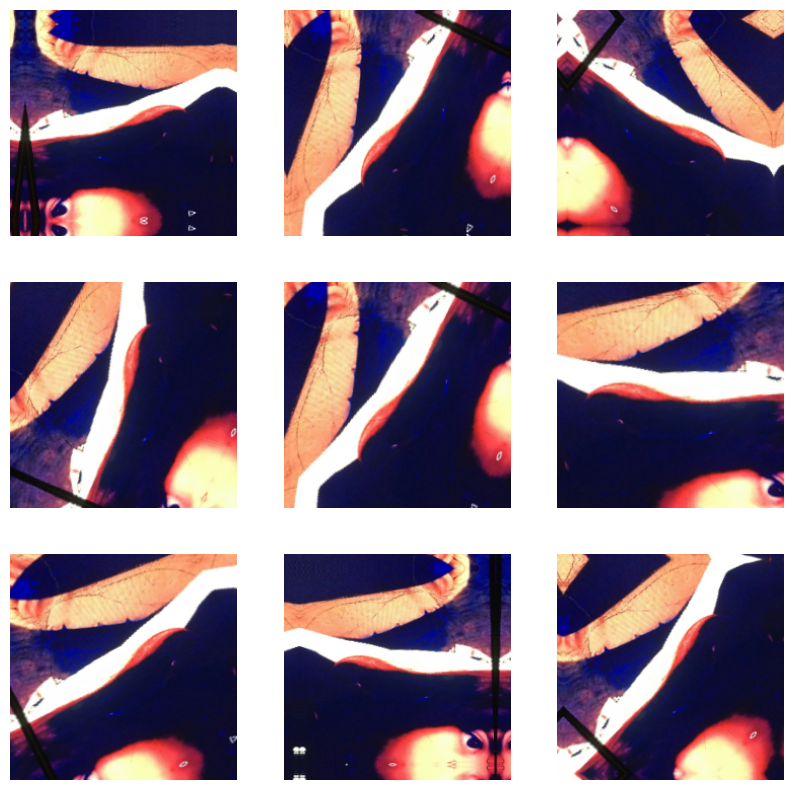

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [18]:
base_model.trainable = False

In [19]:
#base_model.summary()

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [21]:
base_model.trainable = False

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [23]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

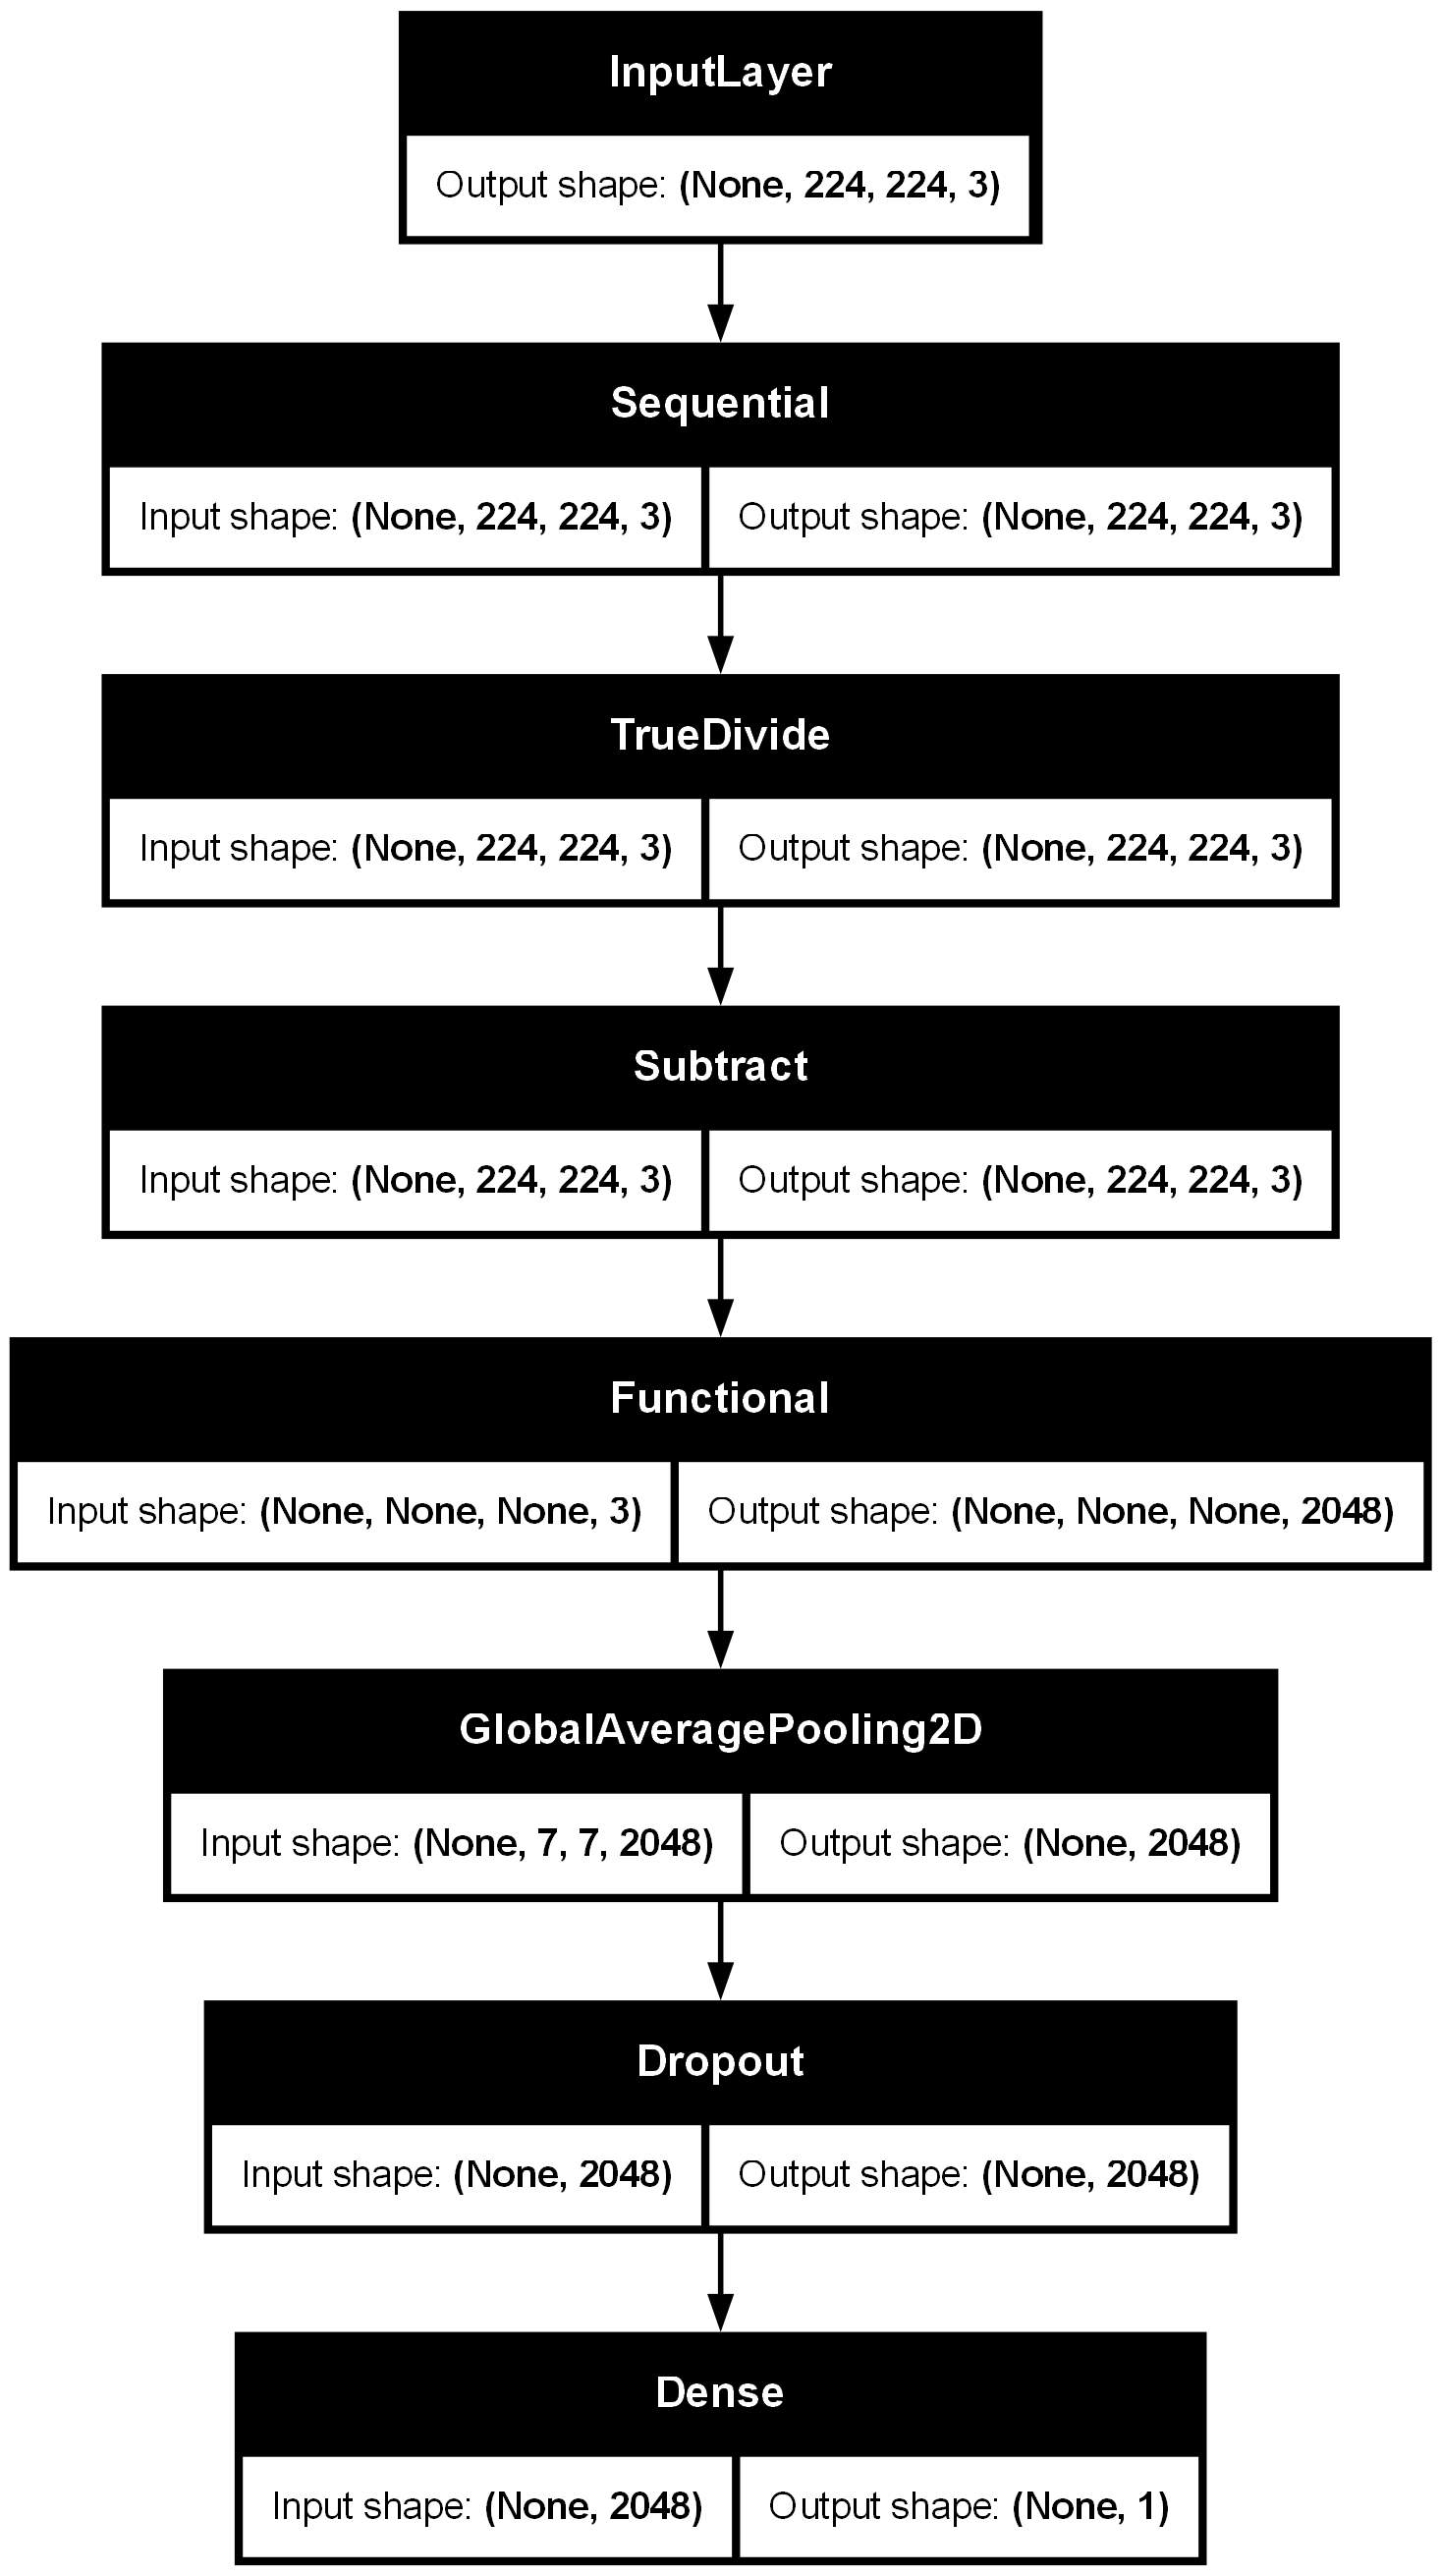

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

104/104 ━━━━━━━━━━━━━━━━━━━━ 37s 343ms/step - accuracy: 0.5563 - loss: 0.7582


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.56


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 227s 433ms/step - accuracy: 0.5381 - loss: 0.7117 - val_accuracy: 0.6064 - val_loss: 0.6623
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 225s 433ms/step - accuracy: 0.5614 - loss: 0.6816 - val_accuracy: 0.6236 - val_loss: 0.6508
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 224s 432ms/step - accuracy: 0.5794 - loss: 0.6696 - val_accuracy: 0.6284 - val_loss: 0.6432
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 224s 431ms/step - accuracy: 0.6044 - loss: 0.6586 - val_accuracy: 0.6314 - val_loss: 0.6397
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 222s 427ms/step - accuracy: 0.6145 - loss: 0.6526 - val_accuracy: 0.6398 - val_loss: 0.6336
Epoch 6/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 223s 430ms/step - accuracy: 0.6222 - loss: 0.6450 - val_accuracy: 0.6452 - val_loss: 0.6305
Epoch 7/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 222s 428ms/step - accuracy: 0.6267 - loss: 0.6442 - val_accuracy: 0.6500 - val_loss: 0.6276
Epoch 8/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 224s 432ms/step - accuracy: 0.6306 -

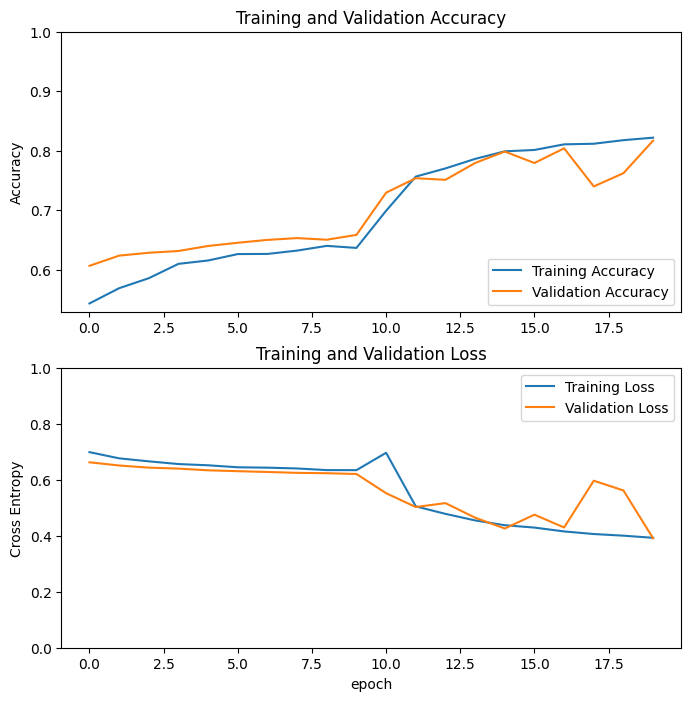

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [46]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.8297 - loss: 0.3845 - val_accuracy: 0.8151 - val_loss: 0.4180
Epoch 12/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.8278 - loss: 0.3772 - val_accuracy: 0.8046 - val_loss: 0.4241
Epoch 13/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.8389 - loss: 0.3646 - val_accuracy: 0.8028 - val_loss: 0.4502
Epoch 14/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.8404 - loss: 0.3618 - val_accuracy: 0.8199 - val_loss: 0.4462
Epoch 15/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.8393 - loss: 0.3573 - val_accuracy: 0.8169 - val_loss: 0.4417
Epoch 16/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.8424 - loss: 0.3524 - val_accuracy: 0.7977 - val_loss: 0.5303
Epoch 17/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.8490 - loss: 0.3441 - val_accuracy: 0.8229 - val_loss: 0.4473
Epoch 18/20
519/519 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.8514 - loss: 0.3337 - 

In [47]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

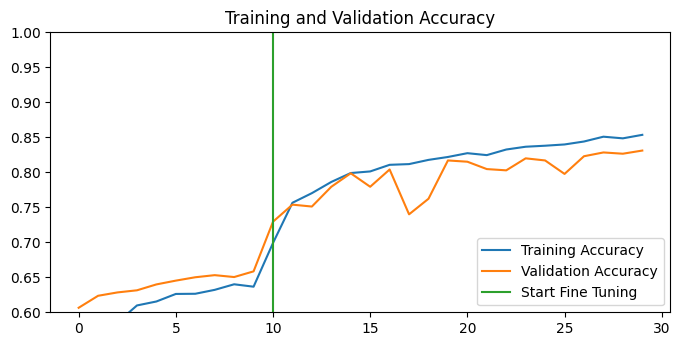

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs, initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

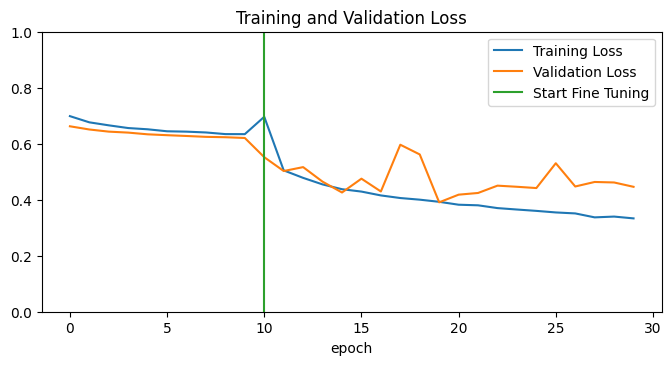

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs, initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 611ms/step - accuracy: 0.8196 - loss: 0.4956
Test accuracy : 0.8161057829856873


Predictions:
 [1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1]
Labels:
 [1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1]


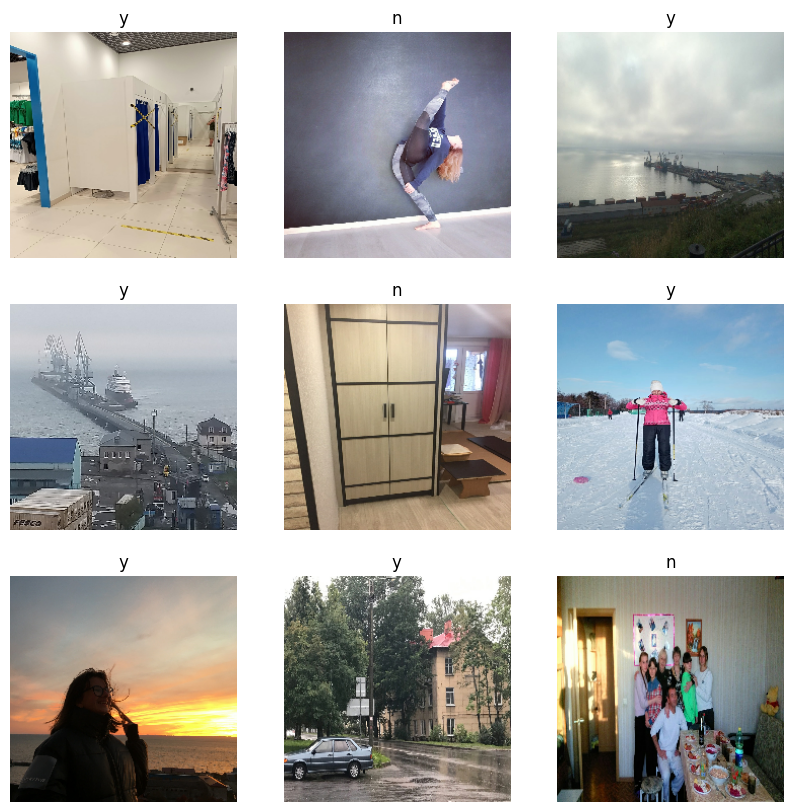

In [59]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [52]:
model.save('resNet50_81.keras')